# MINI PROJECT MA3022 ALJABAR LINEAR
- Renaldy Arief Susanto (13522022)

## STEP 0: Import + Seeding

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import warnings
from rich import print as rprint
warnings.filterwarnings('ignore')
np.random.seed(10123010 + 10123042 + 10221006 + 10221050 + 13522022) # ;)

## STEP 1: Load Data + Split Train Test

In [23]:
# this code was generated by Claude AI.

"""
Eigenfaces and Singular Value Decomposition
Mini-Project Implementation

This notebook implements the complete eigenfaces pipeline:
1. Load and preprocess face images
2. Compute mean face and center data
3. Apply SVD to find eigenfaces
4. Project faces into eigenface space
5. Classify using nearest neighbor
6. Evaluate accuracy and reconstruct faces
"""

def load_att_faces(data_dir, subjects=range(1, 7)):
    """
    Load AT&T face database images
    
    Parameters:
    - data_dir: path to directory containing s1, s2, ..., s6 folders
    - subjects: which subjects to load (default: 1-6)
    - img_size: expected image size (height, width)
    
    Returns:
    - faces: array of shape (n_images, height*width)
    - labels: array of subject labels
    """
    faces = []
    labels = []
    
    for subject in subjects:
        subject_dir = os.path.join(data_dir, f's{subject}')
        if not os.path.exists(subject_dir):
            raise Exception(f"The dataset doesn't exist for {subject_dir}")
        else:
            # Load actual images
            for img_num in range(1, 9):
                img_path = os.path.join(subject_dir, f'{img_num}.pgm')
                if os.path.exists(img_path):
                    img = Image.open(img_path).convert('L')
                    faces.append(np.array(img).flatten())
                    labels.append(subject)
    
    return np.array(faces, dtype=np.float32), np.array(labels)

def split_train_test(faces, labels, train_per_subject=4):
    """
    Split faces into training and test sets
    
    Parameters:
    - faces: array of flattened face images
    - labels: array of subject labels
    - train_per_subject: number of images per subject for training
    
    Returns:
    - train_faces, train_labels, test_faces, test_labels
    """
    train_faces, train_labels = [], []
    test_faces, test_labels = [], []
    
    for subject in np.unique(labels):
        subject_faces = faces[labels == subject]
        subject_labels = labels[labels == subject]
        
        # First train_per_subject images for training
        train_faces.extend(subject_faces[:train_per_subject])
        train_labels.extend(subject_labels[:train_per_subject])
        
        # Remaining images for testing
        test_faces.extend(subject_faces[train_per_subject:])
        test_labels.extend(subject_labels[train_per_subject:])
    
    return (np.array(train_faces), np.array(train_labels), 
            np.array(test_faces), np.array(test_labels))

# Load the data
rprint("Loading face data...")
# Note: Replace 'att_faces' with your actual data directory path
faces, labels = load_att_faces('att_faces')
rprint(f"Loaded {len(faces)} faces from {len(np.unique(labels))} subjects")
rprint(f"Each face has {faces.shape[1]} pixels")

# Split into train/test
train_faces, train_labels, test_faces, test_labels = split_train_test(faces, labels)
rprint(f"Training set: {len(train_faces)} faces")
rprint(f"Test set: {len(test_faces)} faces")

Loading face data...

Loaded 48 faces from 6 subjects

Each face has 10304 pixels

Training set: 24 faces

Test set: 24 faces

## STEP 2: COMPUTE MEAN FACE AND CENTER DATA

In [24]:
rprint("\nComputing mean face and centering data...")

# Compute mean face from training data
mean_face = np.mean(train_faces, axis=0)
rprint(f"Mean face computed from {len(train_faces)} training images")

# Center the training data
train_centered = train_faces - mean_face
rprint(f"Training data centered: shape {train_centered.shape}")

Computing mean face and centering data...

Mean face computed from 24 training images

Training data centered: shape (24, 10304)

## STEP 3: SINGULAR VALUE DECOMPOSITION

In [25]:
rprint("Performing SVD...")

# Perform thin SVD on centered training data
# Note: We transpose because sklearn convention is samples × features
# but SVD convention is features × samples
U, s, Vt = np.linalg.svd(train_centered.T, full_matrices=False)

rprint(f"SVD completed:")
rprint(f"  U (eigenfaces): {U.shape}")
rprint(f"  Singular values: {s.shape}")
rprint(f"  V^T: {Vt.shape}")

# The eigenfaces are the columns of U
eigenfaces = U
n_components = len(s)
rprint(f"Found {n_components} eigenfaces")

Performing SVD...

SVD completed:

U (eigenfaces): (10304, 24)

Singular values: (24,)

V^T: (24, 24)

Found 24 eigenfaces

## STEP 4: VISUALIZE MEAN FACE AND EIGENFACES

Visualizing mean face and first 6 eigenfaces...

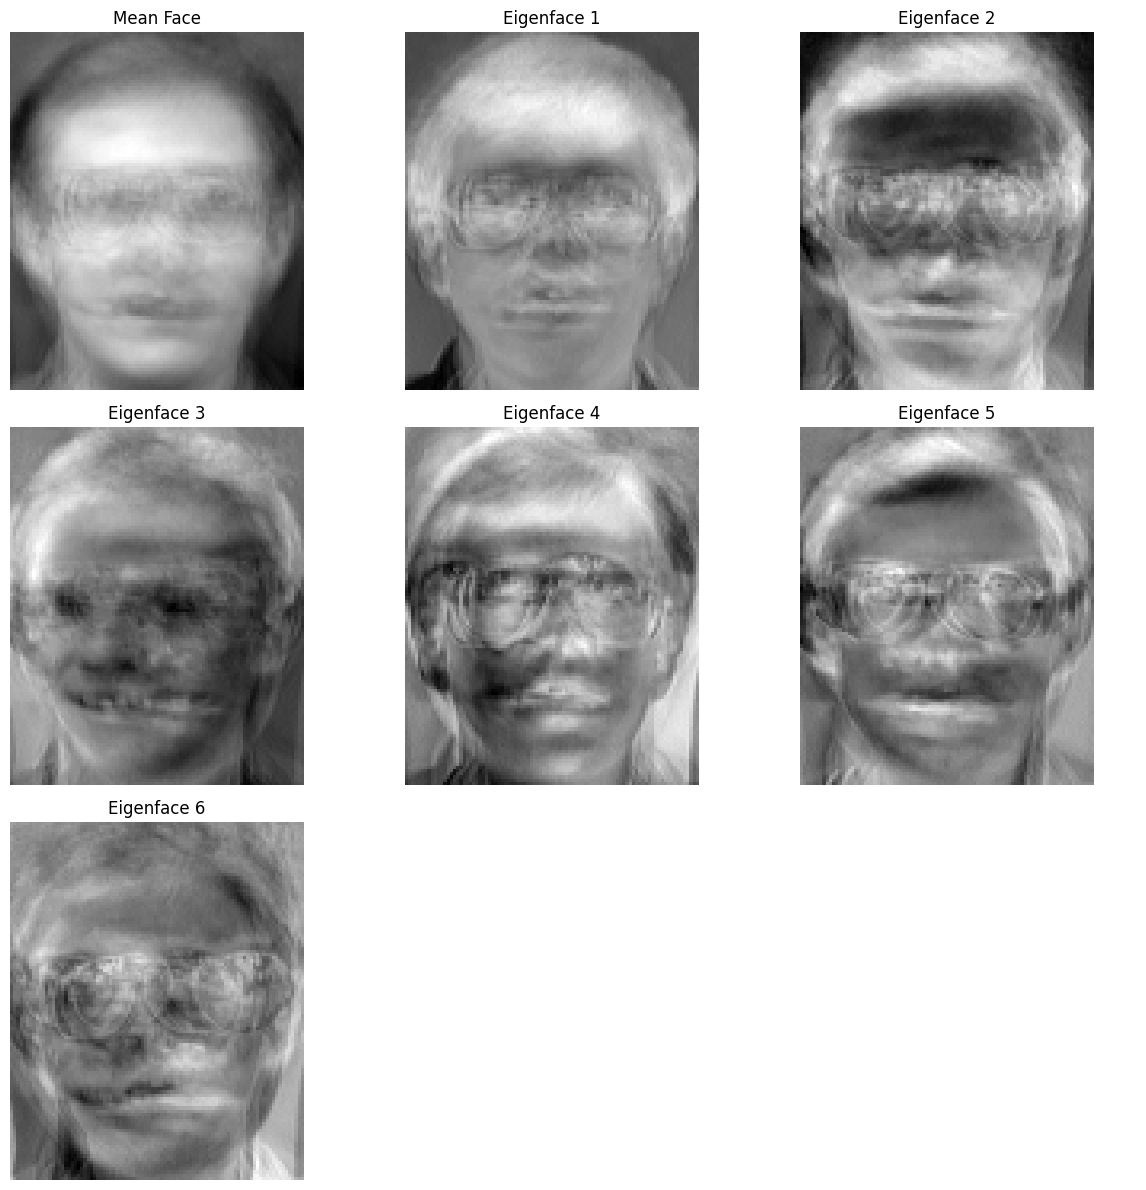

In [26]:
def plot_faces(faces, titles, img_shape=(112, 92), cols=3):
    """Plot a grid of faces"""
    n_faces = len(faces)
    rows = (n_faces + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_faces):
        row, col = i // cols, i % cols
        face = faces[i].reshape(img_shape)
        axes[row, col].imshow(face, cmap='gray')
        axes[row, col].set_title(titles[i])
        axes[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(n_faces, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

rprint("\nVisualizing mean face and first 6 eigenfaces...")

# Prepare faces for visualization
faces_to_plot = [mean_face] + [eigenfaces[:, i] for i in range(6)]
titles = ['Mean Face'] + [f'Eigenface {i+1}' for i in range(6)]

plot_faces(faces_to_plot, titles)

## STEP 5: PROJECT FACES INTO EIGENFACE SPACE

In [27]:
def project_faces(faces, mean_face, eigenfaces, k):
    """
    Project faces into k-dimensional eigenface space
    
    Parameters:
    - faces: array of face images
    - mean_face: mean face vector
    - eigenfaces: matrix of eigenfaces (columns are eigenfaces)
    - k: number of eigenfaces to use
    
    Returns:
    - projected: array of projected face coordinates
    """
    centered_faces = faces - mean_face
    Uk = eigenfaces[:, :k]
    projected = (Uk.T @ centered_faces.T).T
    return projected

# Project training and test faces for both k=10 and k=20
k_values = [10, 20]
results = {}

for k in k_values:
    rprint(f"\nProjecting faces into {k}-dimensional eigenface space...")
    
    # Project training faces
    train_projected = project_faces(train_faces, mean_face, eigenfaces, k)
    rprint(f"Training faces projected: {train_projected.shape}")
    
    # Project test faces
    test_projected = project_faces(test_faces, mean_face, eigenfaces, k)
    rprint(f"Test faces projected: {test_projected.shape}")
    
    results[k] = {
        'train_projected': train_projected,
        'test_projected': test_projected
    }

Projecting faces into 10-dimensional eigenface space...

Training faces projected: (24, 10)

Test faces projected: (24, 10)

Projecting faces into 20-dimensional eigenface space...

Training faces projected: (24, 20)

Test faces projected: (24, 20)

## STEP 6: NEAREST NEIGHBOR CLASSIFICATION

In [28]:
def classify_faces(train_projected, train_labels, test_projected):
    """
    Classify test faces using nearest neighbor in eigenface space
    
    Parameters:
    - train_projected: training faces in eigenface space
    - train_labels: training face labels
    - test_projected: test faces in eigenface space
    
    Returns:
    - predictions: predicted labels for test faces
    """
    # Compute distances between all test and training faces
    distances = cdist(test_projected, train_projected, metric='euclidean')
    
    # Find nearest neighbor for each test face
    nearest_indices = np.argmin(distances, axis=1)
    predictions = train_labels[nearest_indices]
    
    return predictions

rprint("\nPerforming nearest neighbor classification...")

accuracy_results = {}

for k in k_values:
    rprint(f"\nClassification with k={k}:")
    
    # Get projected data
    train_proj = results[k]['train_projected']
    test_proj = results[k]['test_projected']
    
    # Classify
    predictions = classify_faces(train_proj, train_labels, test_proj)
    
    # Compute accuracy
    total = len(test_labels)
    miss = 0
    for actual_label, prediction in zip(test_labels, predictions):
        print(f"Our prediction {prediction}, and the actual label is {actual_label}")
        if prediction != actual_label:
            print("Missed :(")
            miss += 1

    
    accuracy = ((total - miss) / total) # accuracy calculation
    accuracy_results[k] = accuracy

    rprint(f"  Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    rprint(f"  Correct: {np.sum(predictions == test_labels)}/{len(test_labels)}")

Performing nearest neighbor classification...

Classification with k=10:

Our prediction 1, and the actual label is 1
Our prediction 1, and the actual label is 1
Our prediction 1, and the actual label is 1
Our prediction 1, and the actual label is 1
Our prediction 2, and the actual label is 2
Our prediction 2, and the actual label is 2
Our prediction 2, and the actual label is 2
Our prediction 2, and the actual label is 2
Our prediction 3, and the actual label is 3
Our prediction 3, and the actual label is 3
Our prediction 3, and the actual label is 3
Our prediction 3, and the actual label is 3
Our prediction 4, and the actual label is 4
Our prediction 4, and the actual label is 4
Our prediction 4, and the actual label is 4
Our prediction 4, and the actual label is 4
Our prediction 5, and the actual label is 5
Our prediction 5, and the actual label is 5
Our prediction 5, and the actual label is 5
Our prediction 5, and the actual label is 5
Our prediction 6, and the actual label is 6
Our prediction 6, and the actual label is 6
Our prediction 6, and the actual

Accuracy: 1.000 (100.0%)

Correct: 24/24

Classification with k=20:

Our prediction 1, and the actual label is 1
Our prediction 1, and the actual label is 1
Our prediction 1, and the actual label is 1
Our prediction 1, and the actual label is 1
Our prediction 2, and the actual label is 2
Our prediction 2, and the actual label is 2
Our prediction 2, and the actual label is 2
Our prediction 2, and the actual label is 2
Our prediction 3, and the actual label is 3
Our prediction 3, and the actual label is 3
Our prediction 3, and the actual label is 3
Our prediction 3, and the actual label is 3
Our prediction 4, and the actual label is 4
Our prediction 4, and the actual label is 4
Our prediction 4, and the actual label is 4
Our prediction 4, and the actual label is 4
Our prediction 5, and the actual label is 5
Our prediction 5, and the actual label is 5
Our prediction 5, and the actual label is 5
Our prediction 5, and the actual label is 5
Our prediction 6, and the actual label is 6
Our prediction 6, and the actual label is 6
Our prediction 6, and the actual

Accuracy: 1.000 (100.0%)

Correct: 24/24

## STEP 7: RESULTS SUMMARY

In [29]:
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

print("\nAccuracy Results:")
for k, accuracy in accuracy_results.items():
    rprint(f"k={k:2d}: {accuracy:.3f} ({accuracy*100:.1f}%)")

rprint(f"\nBest performance: k={max(accuracy_results.keys(), key=lambda x: accuracy_results[x])}")


FINAL RESULTS

Accuracy Results:


k=10: 1.000 (100.0%)

k=20: 1.000 (100.0%)

Best performance: k=10

## STEP 8: FACE RECONSTRUCTION

Reconstructing sample face with k=10...

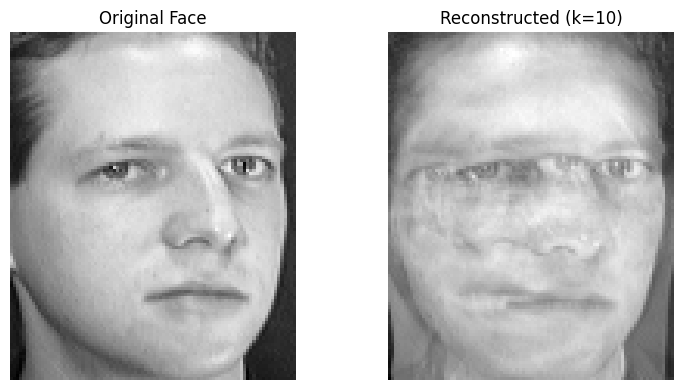

Reconstruction MSE: 680.49

In [30]:
def reconstruct_face(face, mean_face, eigenfaces, k):
    """
    Reconstruct a face using k eigenfaces
    
    Parameters:
    - face: original face vector
    - mean_face: mean face vector
    - eigenfaces: matrix of eigenfaces
    - k: number of eigenfaces to use
    
    Returns:
    - reconstructed: reconstructed face vector
    """
    # Project face into eigenface space
    centered_face = face - mean_face
    Uk = eigenfaces[:, :k]
    coefficients = Uk.T @ centered_face
    
    # Reconstruct face
    reconstructed = Uk @ coefficients + mean_face
    return reconstructed

rprint("\nReconstructing sample face with k=10...")

# Choose a test face for reconstruction
test_idx = 0
original_face = test_faces[test_idx]
reconstructed_face = reconstruct_face(original_face, mean_face, eigenfaces, 10)

# Plot original vs reconstructed
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(original_face.reshape(112, 92), cmap='gray')
axes[0].set_title('Original Face')
axes[0].axis('off')

axes[1].imshow(reconstructed_face.reshape(112, 92), cmap='gray')
axes[1].set_title('Reconstructed (k=10)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Compute reconstruction error
mse = np.mean((original_face - reconstructed_face)**2)
rprint(f"Reconstruction MSE: {mse:.2f}")

## STEP 9: ANALYSIS AND INSIGHTS

==================================================

ANALYSIS AND INSIGHTS

==================================================

Singular Value Analysis:

Total singular values: 24

Largest singular value: 8704.47

Smallest singular value: 0.00

Variance explained by first k eigenfaces:

k= 5: 0.705 (70.5%)

k=10: 0.861 (86.1%)

k=15: 0.940 (94.0%)

k=20: 0.986 (98.6%)

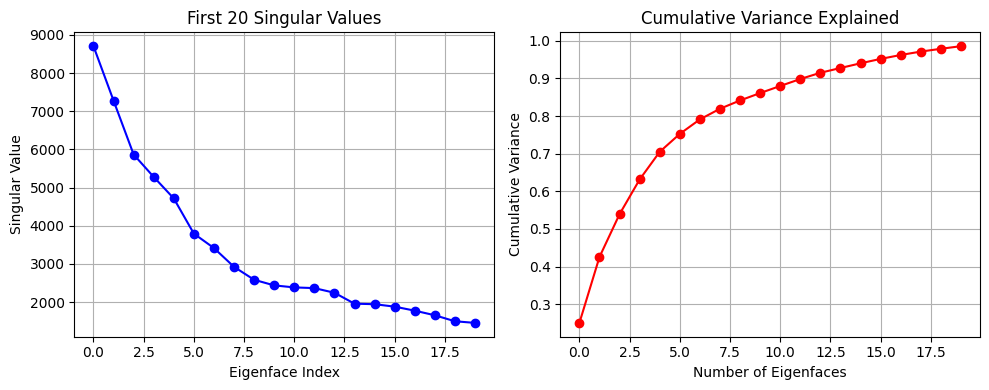

In [31]:
rprint("\n" + "="*50)
rprint("ANALYSIS AND INSIGHTS")
rprint("="*50)

# Analyze singular values
rprint("\nSingular Value Analysis:")
rprint(f"Total singular values: {len(s)}")
rprint(f"Largest singular value: {s[0]:.2f}")
rprint(f"Smallest singular value: {s[-1]:.2f}")

# Compute cumulative variance explained
total_variance = np.sum(s**2)
cumulative_variance = np.cumsum(s**2) / total_variance

rprint(f"\nVariance explained by first k eigenfaces:")
for k in [5, 10, 15, 20]:
    if k <= len(s):
        variance_explained = cumulative_variance[k-1]
        rprint(f"k={k:2d}: {variance_explained:.3f} ({variance_explained*100:.1f}%)")

# Plot singular values
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(s[:20], 'bo-')
plt.title('First 20 Singular Values')
plt.xlabel('Eigenface Index')
plt.ylabel('Singular Value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_variance[:20], 'ro-')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Eigenfaces')
plt.ylabel('Cumulative Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

## STEP 10: FINAL SUMMARY

In [32]:
rprint("\n" + "="*50)
rprint("PROJECT SUMMARY")
rprint("="*50)

rprint(f"""
Dataset: 6 subjects, 8 images each (48 total faces)
Training: 4 images per subject (24 faces)
Testing: 4 images per subject (24 faces)
Image size: 92×112 pixels (10,304 dimensions)

Compression achieved:
- Original: 10,304 dimensions per face
- Compressed (k=10): 10 dimensions per face
- Compression ratio: {10304/10:.0f}:1 ({10/10304*100:.2f}% of original)

Classification Results:
- k=10: {accuracy_results[10]:.1%} accuracy
- k=20: {accuracy_results[20]:.1%} accuracy

Key Insights:
1. SVD successfully identified the principal modes of facial variation
2. Just {10} eigenfaces can capture enough information for face recognition
3. The first few eigenfaces capture the most significant facial features
4. Higher k values generally improve accuracy but with diminishing returns
5. Face reconstruction is possible with surprisingly few components

This demonstrates the power of SVD for dimensionality reduction and
feature extraction in high-dimensional data like face images.
""")

==================================================

PROJECT SUMMARY

==================================================

Dataset: 6 subjects, 8 images each (48 total faces)
Training: 4 images per subject (24 faces)
Testing: 4 images per subject (24 faces)
Image size: 92×112 pixels (10,304 dimensions)

Compression achieved:
- Original: 10,304 dimensions per face
- Compressed (k=10): 10 dimensions per face
- Compression ratio: 1030:1 (0.10% of original)

Classification Results:
- k=10: 100.0% accuracy
- k=20: 100.0% accuracy

Key Insights:
1. SVD successfully identified the principal modes of facial variation
2. Just 10 eigenfaces can capture enough information for face recognition
3. The first few eigenfaces capture the most significant facial features
4. Higher k values generally improve accuracy but with diminishing returns
5. Face reconstruction is possible with surprisingly few components

This demonstrates the power of SVD for dimensionality reduction and
feature extraction in high-dimensional data like face images.